# `bagreader` example

In [1]:
pip install bagpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import pytz
import warnings
# from google.colab import drive
# drive.mount('/content/drive')
warnings.filterwarnings("ignore")

In [3]:
timezone = pytz.timezone("America/Chicago")

In [4]:
def conv_time(unix_timestamp):
    unix_format = int(unix_timestamp)
    dt_format = datetime.datetime.fromtimestamp(unix_format, timezone)
    dt_str = dt_format.strftime("%Y-%m-%d %H:%M:%S (%Z)")
    return dt_str

In [5]:
b = bagreader("/Users/apple/Desktop/VU/Junior/CS3891_Autonomous/2023_11_17_21_34_48_2T3MWRFVXLW056972trustaimerge.bag")
csvfiles = []
for t in b.topics:
    data = b.message_by_topic(t)
    csvfiles.append(data)

[INFO]  Data folder /Users/apple/Desktop/VU/Junior/CS3891_Autonomous/2023_11_17_21_34_48_2T3MWRFVXLW056972trustaimerge already exists. Not creating.


In [6]:
filePath = '/Users/apple/Desktop/VU/Junior/CS3891_Autonomous/2023_11_17_21_34_48_2T3MWRFVXLW056972trustaimerge/'

In [7]:
vel_x = pd.read_csv(filePath+"car-state-vel_x.csv")
vel_x.shape

(107125, 2)

In [8]:
cruise_state = pd.read_csv(filePath+"cruise_state.csv")
cruise_state.shape

(2734, 4)

In [9]:
accel_cmd = pd.read_csv(filePath+"cmd_accel_pre.csv")
accel_cmd.shape

(8832, 2)

In [10]:
lead_dist = pd.read_csv(filePath+"lead_dist.csv")
lead_dist.shape

(13804, 2)

In [11]:
vel_x.columns = ['timestamp','vel_x']
cruise_state.columns = ['timestamp','cruise_state','y','z']
accel_cmd.columns = ['timestamp','accel_cmd']
lead_dist.columns = ['timestamp','lead_dist']

In [12]:
control_start_dt = cruise_state[cruise_state.cruise_state==1].timestamp.min()

In [13]:
vel_x = vel_x[vel_x.timestamp>=control_start_dt]
cruise_state = cruise_state[['timestamp','cruise_state']][cruise_state.timestamp>=control_start_dt]
accel_cmd = accel_cmd[accel_cmd.timestamp>=control_start_dt]
lead_dist = lead_dist[lead_dist.timestamp>=control_start_dt]

In [14]:
vel_x.shape,cruise_state.shape,accel_cmd.shape,lead_dist.shape

((52515, 2), (1368, 2), (5333, 2), (6806, 2))

In [15]:
accel_cmd.reset_index(inplace=True,drop=True)
accelx_c = accel_cmd.copy()
accelx_c.index += 1
accelx_c.columns = ['time_prev','acc_prev']
accelx_concat = pd.concat([accel_cmd,accelx_c],axis=1)
accelx_concat.dropna(inplace=True)
accelx_concat.head(1)

,timestamp,accel_cmd,time_prev,acc_prev
1,1.700258e+09,0.5,1.700258e+09,0.5


In [16]:
# jerk calculation
accelx_concat['jerk'] = (accelx_concat.accel_cmd-accelx_concat.acc_prev)/(accelx_concat.timestamp-accelx_concat.time_prev)

In [17]:
merge_data = pd.merge_asof(vel_x,cruise_state,on='timestamp',allow_exact_matches=False,direction='backward')
merge_data = pd.merge_asof(merge_data,accel_cmd,on='timestamp',allow_exact_matches=False,direction='backward')
merge_data = pd.merge_asof(merge_data,lead_dist,on='timestamp',allow_exact_matches=False,direction='backward')
merge_data = pd.merge_asof(merge_data,accelx_concat[['timestamp','jerk']],on='timestamp',allow_exact_matches=False,direction='backward')
merge_data.shape

(52515, 6)

In [18]:
merge_data.dropna(inplace=True)
merge_data.shape

(52493, 6)

In [19]:
merge_data['time_hdw'] = merge_data.lead_dist/merge_data.vel_x

In [20]:
merge_data.reset_index(inplace=True,drop=True)

In [21]:
start_dt = merge_data.timestamp.min()
end_dt = merge_data.timestamp.max()
duration = end_dt - start_dt
duration

683.3960635662079

In [22]:
m, s = divmod(duration, 60)
h, m = divmod(m, 60)
print("The start datetime of TrustAI's experiment is: ", conv_time(start_dt))
print("The end datetime of TrustAI's experiment is: ", conv_time(end_dt))
print("The total duration is: %d:%02d:%02d" % (h, m, s))

The start datetime of TrustAI's experiment is:  2023-11-17 15:46:31 (CST)
The end datetime of TrustAI's experiment is:  2023-11-17 15:57:54 (CST)
The total duration is: 0:11:23


In [23]:
avg_speed = merge_data.vel_x.sum() / merge_data.shape[0]
print("The average speed of the vehicle is:", round(avg_speed,2), "m/s,",round(0.621371*(3600/1000)*avg_speed,2),"MPH.")

The average speed of the vehicle is: 5.73 m/s, 12.82 MPH.


In [24]:
max_speed = merge_data.vel_x.max()
print("The max speed of the vehicle is:", round(max_speed,2), "m/s,",round(0.621371*(3600/1000)*max_speed,2),"MPH.")

The max speed of the vehicle is: 16.22 m/s, 36.28 MPH.


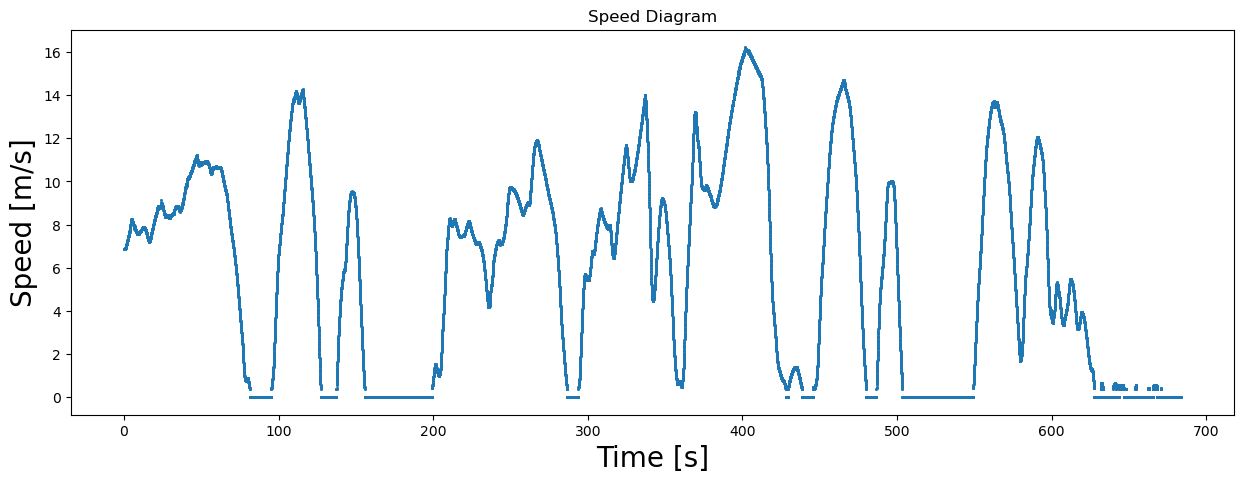

In [25]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data.timestamp-t0, merge_data.vel_x, s=1)
_ = plt.ylabel('Speed [m/s]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)
plt.title("Speed Diagram")
plt.show()

In [26]:
# plt.figure(figsize=[15,5])
# plt.scatter(range(len(v_values)), v_values, s=1)

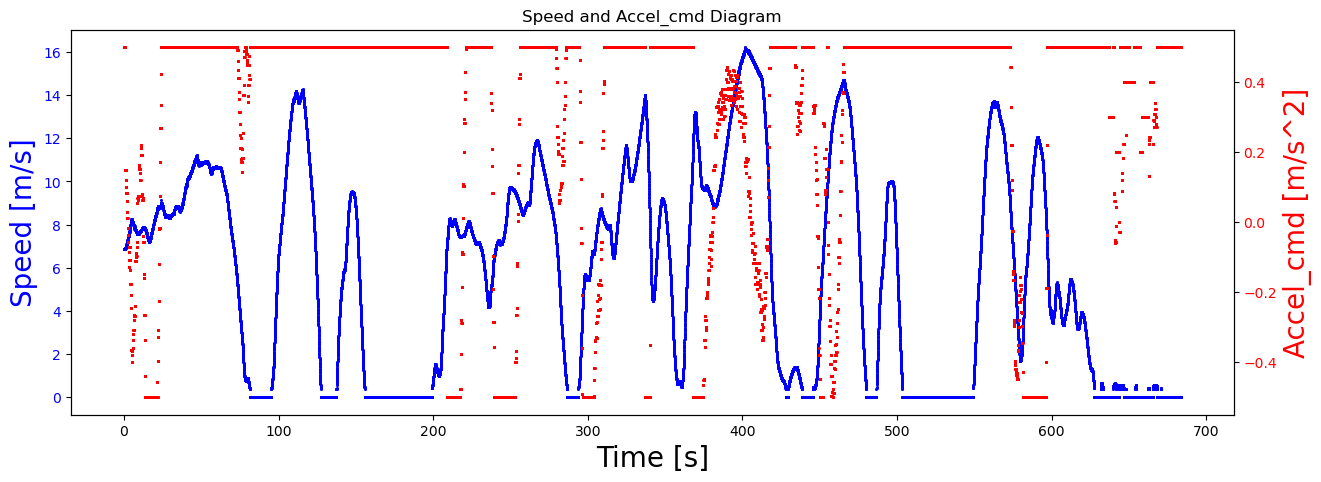

In [27]:
# plt.figure(figsize=[15,5])
# t0 = merge_data.iloc[0].timestamp
# plt.scatter(merge_data.timestamp-t0, merge_data.accel_cmd, s=1)
# _ = plt.ylabel('Accel_cmd [m/s^2]',fontsize=20)
# _ = plt.xlabel('Time [s]',fontsize=20)
# plt.title("Accel_cmd Diagram")
# plt.show()
import matplotlib.pyplot as plt

# Assuming merge_data is your DataFrame and already defined

plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp

# First plot (Speed)
ax1 = plt.gca()  # Get current axis
ax1.scatter(merge_data.timestamp - t0, merge_data.vel_x, s=1, color='b')  # Plot speed in blue
ax1.set_ylabel('Speed [m/s]', fontsize=20, color='b')  # Set y-label for speed
ax1.tick_params(axis='y', labelcolor='b')  # Set tick color for y-axis of speed

# Second plot (Acceleration) on the same x-axis but different y-axis
ax2 = ax1.twinx()  # Create another y-axis that shares the same x-axis
ax2.scatter(merge_data.timestamp - t0, merge_data.accel_cmd, s=1, color='r')  # Plot acceleration in red
ax2.set_ylabel('Accel_cmd [m/s^2]', fontsize=20, color='r')  # Set y-label for acceleration
ax2.tick_params(axis='y', labelcolor='r')  # Set tick color for y-axis of acceleration

# Set common x-axis label and title
ax1.set_xlabel('Time [s]', fontsize=20)
plt.title("Speed and Accel_cmd Diagram")

# Show the plot
plt.show()

In [28]:
#plt.figure(figsize=[15,5])
#plt.scatter(range(len(acc_values)), acc_values, s=1)

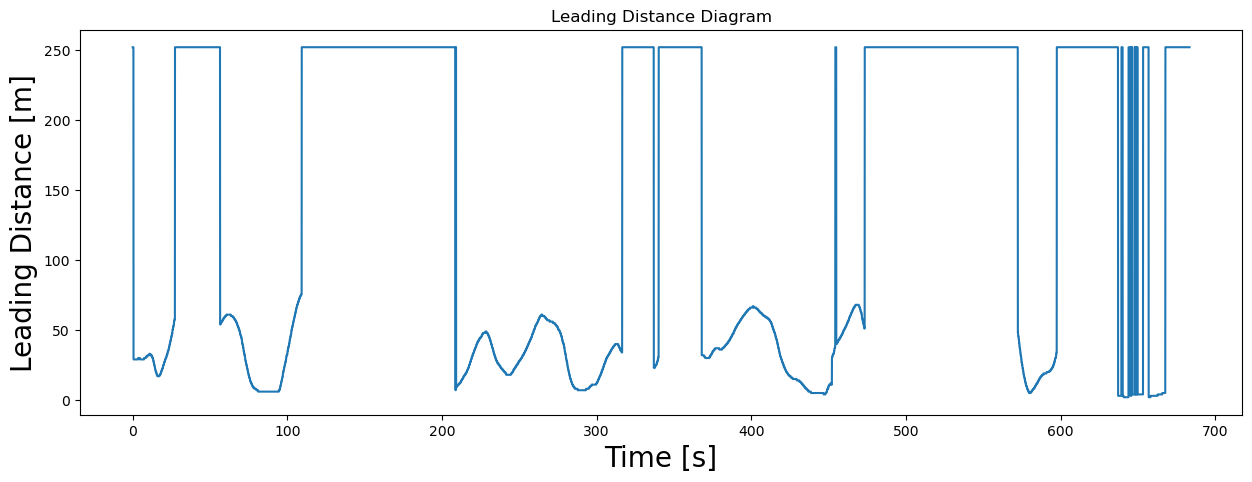

In [29]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.plot(merge_data.timestamp-t0, merge_data.lead_dist)
_ = plt.ylabel('Leading Distance [m]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)
plt.title("Leading Distance Diagram")
plt.show()

# [200-300] s

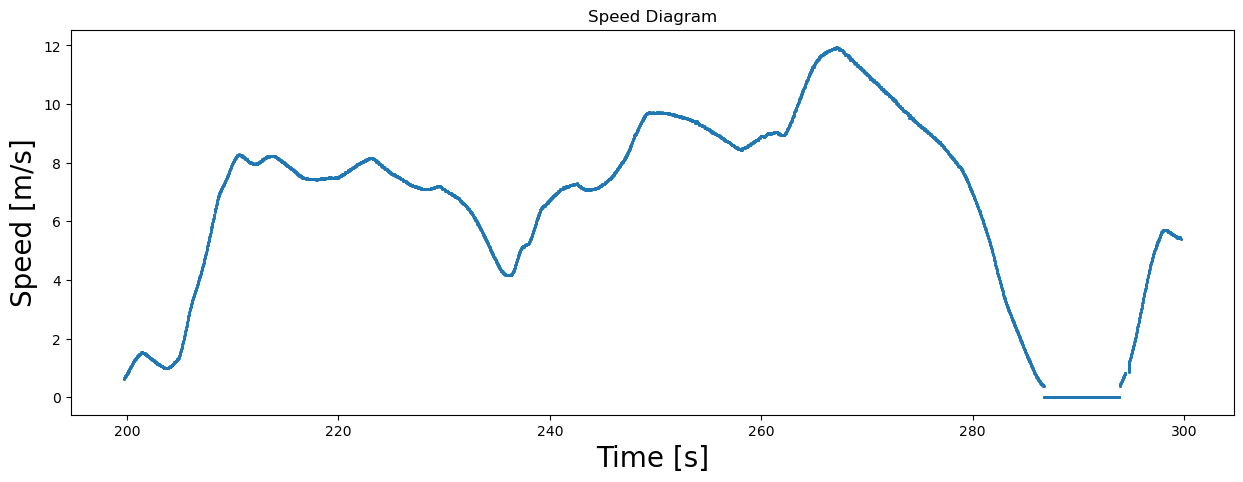

In [30]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[(merge_data.timestamp>=control_start_dt+200)&(merge_data.timestamp<=control_start_dt+300)].timestamp-t0, merge_data[(merge_data.timestamp>=control_start_dt+200)&(merge_data.timestamp<=control_start_dt+300)].vel_x, s=1)
_ = plt.ylabel('Speed [m/s]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)
plt.title("Speed Diagram")
plt.show()

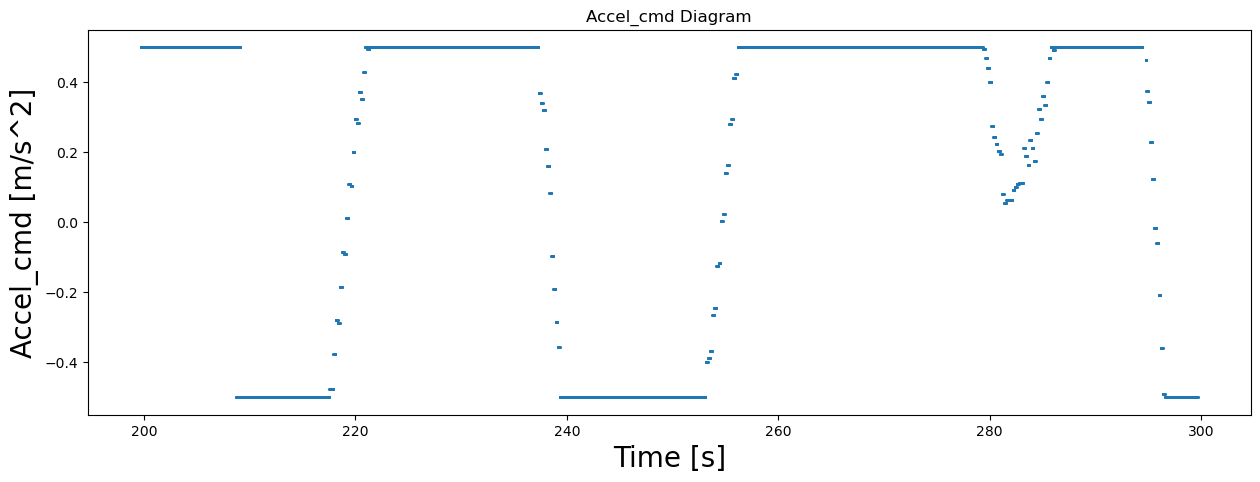

In [31]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[(merge_data.timestamp>=control_start_dt+200)&(merge_data.timestamp<=control_start_dt+300)].timestamp-t0, merge_data[(merge_data.timestamp>=control_start_dt+200)&(merge_data.timestamp<=control_start_dt+300)].accel_cmd, s=1)
_ = plt.ylabel('Accel_cmd [m/s^2]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)
plt.title("Accel_cmd Diagram")
plt.show()

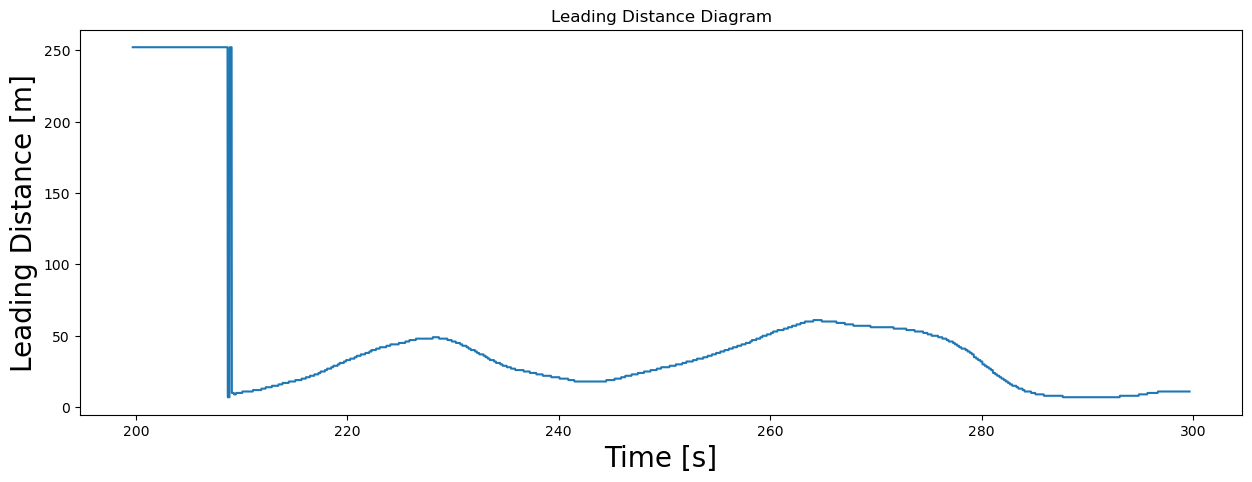

In [32]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.plot(merge_data[(merge_data.timestamp>=control_start_dt+200)&(merge_data.timestamp<=control_start_dt+300)].timestamp-t0, merge_data[(merge_data.timestamp>=control_start_dt+200)&(merge_data.timestamp<=control_start_dt+300)].lead_dist)
_ = plt.ylabel('Leading Distance [m]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)
plt.title("Leading Distance Diagram")
plt.show()

# [300-400] s

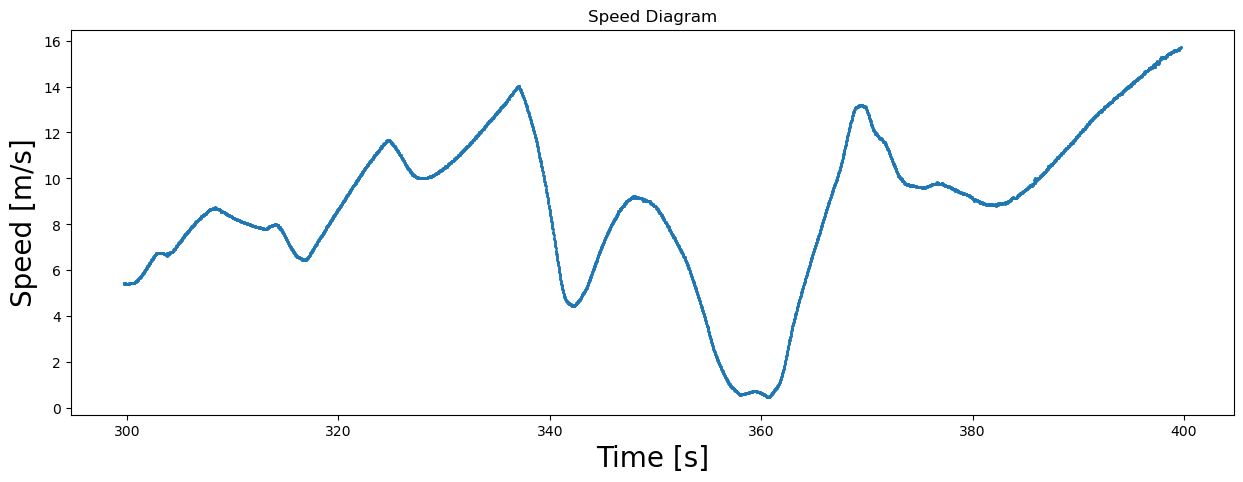

In [33]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[(merge_data.timestamp>=control_start_dt+300)&(merge_data.timestamp<=control_start_dt+400)].timestamp-t0, merge_data[(merge_data.timestamp>=control_start_dt+300)&(merge_data.timestamp<=control_start_dt+400)].vel_x, s=1)
_ = plt.ylabel('Speed [m/s]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)
plt.title("Speed Diagram")
plt.show()

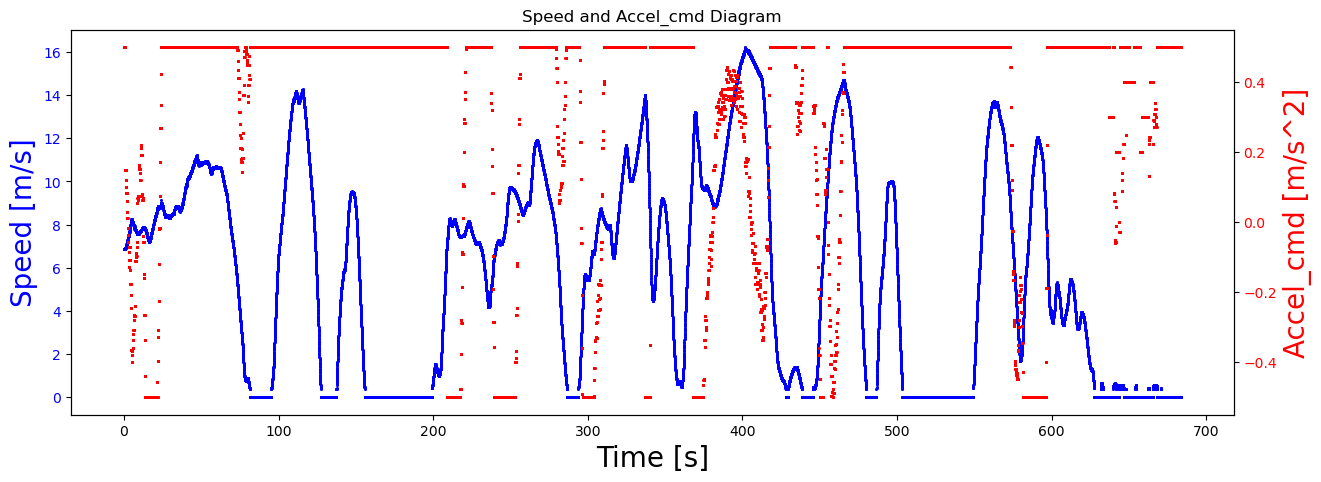

In [78]:
# plt.figure(figsize=[15,5])
# t0 = merge_data.iloc[0].timestamp
# plt.scatter(merge_data[(merge_data.timestamp>=control_start_dt+300)&(merge_data.timestamp<=control_start_dt+400)].timestamp-t0, merge_data[(merge_data.timestamp>=control_start_dt+300)&(merge_data.timestamp<=control_start_dt+400)].accel_cmd, s=1)
# _ = plt.ylabel('Accel_cmd [m/s^2]',fontsize=20)
# _ = plt.xlabel('Time [s]',fontsize=20)
# plt.title("Accel_cmd Diagram")
# plt.show()
import matplotlib.pyplot as plt

# Assuming merge_data is your DataFrame and already defined

plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp

# First plot (Speed)
ax1 = plt.gca()  # Get current axis
ax1.scatter(merge_data.timestamp - t0, merge_data.vel_x, s=1, color='b')  # Plot speed in blue
ax1.set_ylabel('Speed [m/s]', fontsize=20, color='b')  # Set y-label for speed
ax1.tick_params(axis='y', labelcolor='b')  # Set tick color for y-axis of speed

# Second plot (Acceleration) on the same x-axis but different y-axis
ax2 = ax1.twinx()  # Create another y-axis that shares the same x-axis
ax2.scatter(merge_data.timestamp - t0, merge_data.accel_cmd, s=1, color='r')  # Plot acceleration in red
ax2.set_ylabel('Accel_cmd [m/s^2]', fontsize=20, color='r')  # Set y-label for acceleration
ax2.tick_params(axis='y', labelcolor='r')  # Set tick color for y-axis of acceleration

# Set common x-axis label and title
ax1.set_xlabel('Time [s]', fontsize=20)
plt.title("Speed and Accel_cmd Diagram")

# Show the plot
plt.show()


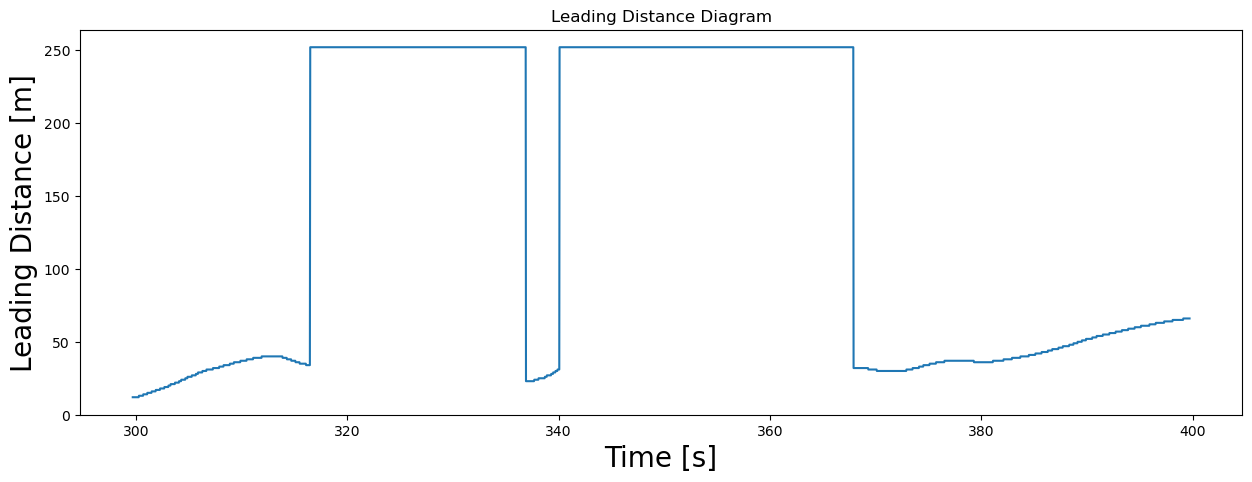

In [35]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.plot(merge_data[(merge_data.timestamp>=control_start_dt+300)&(merge_data.timestamp<=control_start_dt+400)].timestamp-t0, merge_data[(merge_data.timestamp>=control_start_dt+300)&(merge_data.timestamp<=control_start_dt+400)].lead_dist)
_ = plt.ylabel('Leading Distance [m]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)
plt.title("Leading Distance Diagram")
plt.show()

In [36]:
set_speed = pd.read_csv(filePath+"acc-set_speed.csv")
set_speed.shape

(86988, 2)

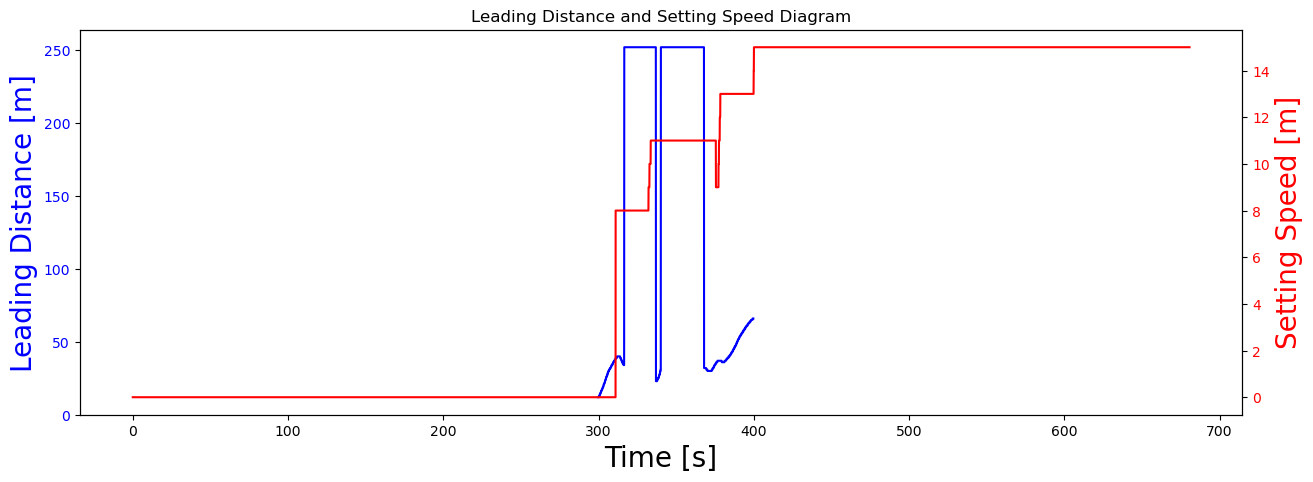

In [79]:
# plt.figure(figsize=[15,5])
# t0 = set_speed[set_speed.Time>=control_start_dt].iloc[0].Time
# plt.plot(set_speed[set_speed.Time>=control_start_dt].Time-t0, set_speed[set_speed.Time>=control_start_dt].data)
# _ = plt.ylabel('Setting Speed [m]',fontsize=20)
# _ = plt.xlabel('Time [s]',fontsize=20)
# plt.title("Setting Speed Diagram")
# plt.show()

import matplotlib.pyplot as plt

# Assuming merge_data and set_speed are your DataFrames and already defined
# Also assuming control_start_dt is defined

plt.figure(figsize=[15,5])

# Plot for Leading Distance
t0 = merge_data.iloc[0].timestamp
ax1 = plt.gca()  # Get current axis
ax1.plot(merge_data[(merge_data.timestamp >= control_start_dt + 300) & (merge_data.timestamp <= control_start_dt + 400)].timestamp - t0, 
         merge_data[(merge_data.timestamp >= control_start_dt + 300) & (merge_data.timestamp <= control_start_dt + 400)].lead_dist, 
         color='b')
ax1.set_ylabel('Leading Distance [m]', fontsize=20, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel('Time [s]', fontsize=20)

# Plot for Setting Speed
t0 = set_speed[set_speed.Time >= control_start_dt].iloc[0].Time
ax2 = ax1.twinx()  # Create another y-axis that shares the same x-axis
ax2.plot(set_speed[set_speed.Time >= control_start_dt].Time - t0, 
         set_speed[set_speed.Time >= control_start_dt].data, 
         color='r')
ax2.set_ylabel('Setting Speed [m]', fontsize=20, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set common title
plt.title("Leading Distance and Setting Speed Diagram")

# Show the plot
plt.show()


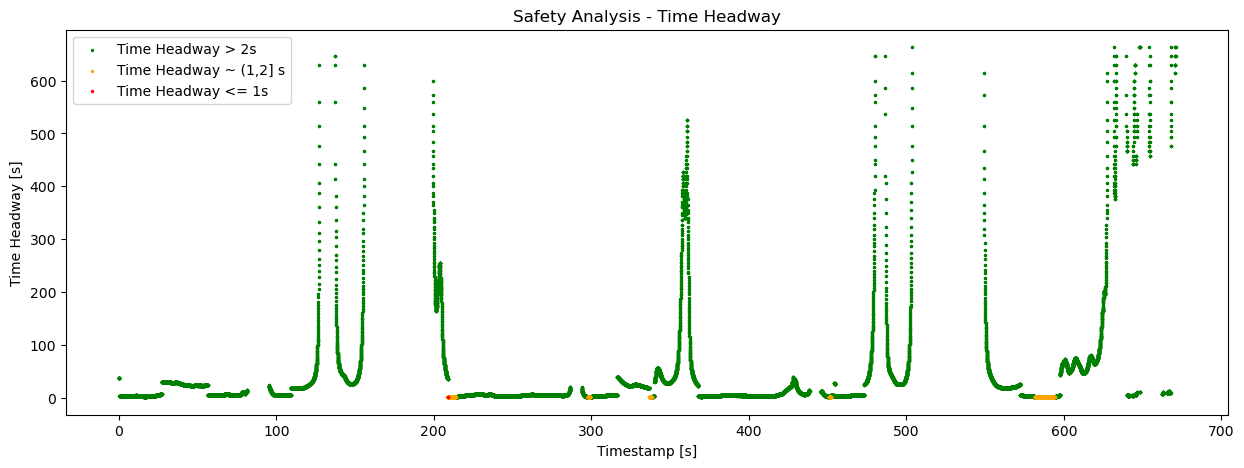

In [38]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[merge_data.time_hdw>2].timestamp-t0, merge_data[merge_data.time_hdw>2].time_hdw,c='green',s=2,label='Time Headway > 2s')
plt.scatter(merge_data[(merge_data.time_hdw>1)&(merge_data.time_hdw<=2)].timestamp-t0, merge_data[(merge_data.time_hdw>1)&(merge_data.time_hdw<=2)].time_hdw,c='orange',s=2,label='Time Headway ~ (1,2] s')
plt.scatter(merge_data[merge_data.time_hdw<=1].timestamp-t0, merge_data[merge_data.time_hdw<=1].time_hdw,c='red',s=2,label='Time Headway <= 1s')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Time Headway [s]")
plt.title("Safety Analysis - Time Headway")
plt.show()

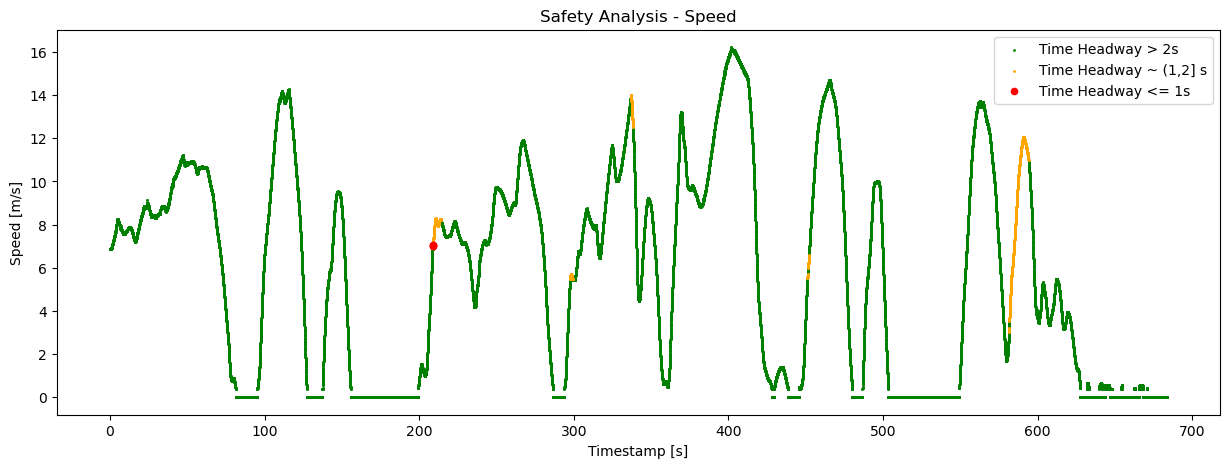

In [81]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[merge_data.time_hdw>2].timestamp-t0, merge_data[merge_data.time_hdw>2].vel_x,c='green',s=1,label='Time Headway > 2s')
plt.scatter(merge_data[(merge_data.time_hdw>1)&(merge_data.time_hdw<=2)].timestamp-t0, merge_data[(merge_data.time_hdw>1)&(merge_data.time_hdw<=2)].vel_x,c='orange',s=1,label='Time Headway ~ (1,2] s')
plt.scatter(merge_data[merge_data.time_hdw<=1].timestamp-t0, merge_data[merge_data.time_hdw<=1].vel_x,c='red',s=20,label='Time Headway <= 1s')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Speed [m/s]")
plt.title("Safety Analysis - Speed")
plt.show()

In [40]:
property_ = (merge_data.accel_cmd>2)|(merge_data.accel_cmd<-3.5)|(merge_data.jerk>5)|(merge_data.jerk<-5)

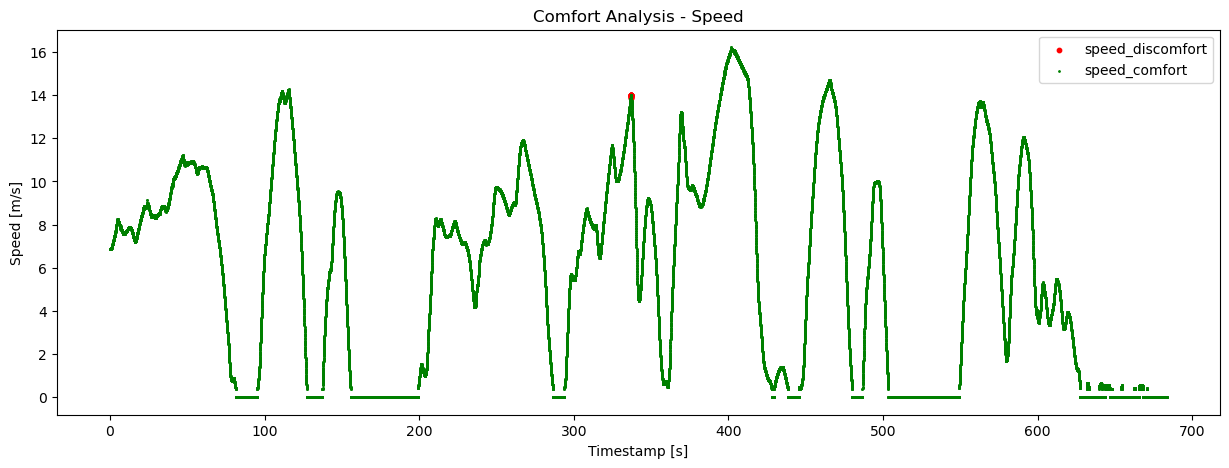

In [41]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[property_].timestamp-t0,merge_data[property_].vel_x,s=10,label='speed_discomfort',color='red')
plt.scatter(merge_data[-property_].timestamp-t0,merge_data[-property_].vel_x,s=1,label='speed_comfort',color='green')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Speed [m/s]")
plt.title("Comfort Analysis - Speed")
plt.show()

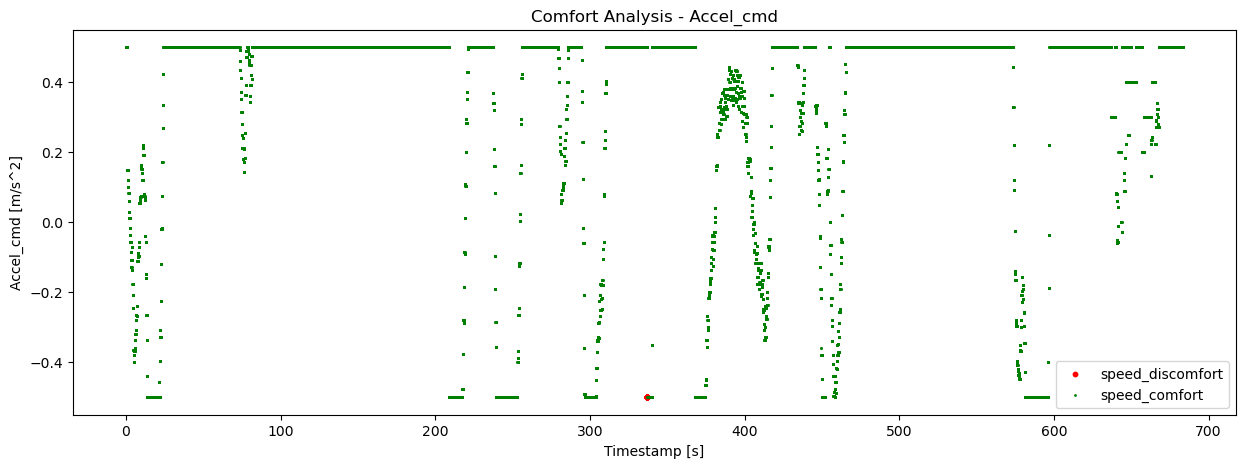

In [42]:
plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[property_].timestamp-t0,merge_data[property_].accel_cmd,s=10,label='speed_discomfort',color='red')
plt.scatter(merge_data[-property_].timestamp-t0,merge_data[-property_].accel_cmd,s=1,label='speed_comfort',color='green')
plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Accel_cmd [m/s^2]")
plt.title("Comfort Analysis - Accel_cmd")
plt.show()

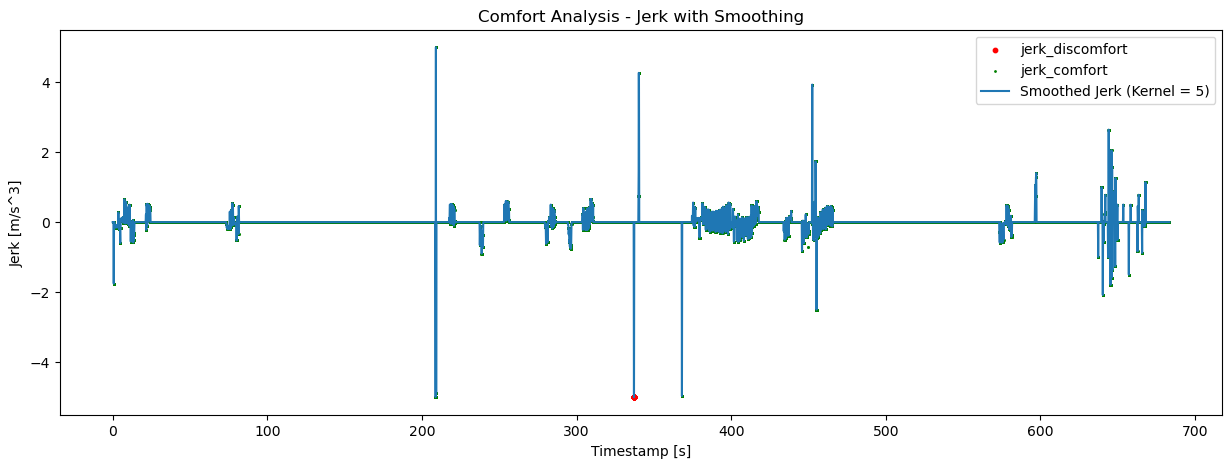

In [82]:
def smooth_jerk(data, kernel_width):
    return data.rolling(window=kernel_width, center=True).mean()
# merge_data['jerk_smoothed_3'] = smooth_jerk(merge_data['jerk'], 3)
merge_data['jerk_smoothed_5'] = smooth_jerk(merge_data['jerk'], 5)
# merge_data['jerk_smoothed_7'] = smooth_jerk(merge_data['jerk'], 7)

plt.figure(figsize=[15,5])
t0 = merge_data.iloc[0].timestamp
plt.scatter(merge_data[property_].timestamp-t0,merge_data[property_].jerk,s=10,label='jerk_discomfort',color='red')
plt.scatter(merge_data[-property_].timestamp-t0,merge_data[-property_].jerk,s=1,label='jerk_comfort',color='green')


jerk_col = 'jerk_smoothed_5'
plt.plot(merge_data.timestamp-t0, merge_data[jerk_col], label='Smoothed Jerk (Kernel = 5)')

plt.legend()
plt.xlabel("Timestamp [s]")
plt.ylabel("Jerk [m/s^3]")
plt.title("Comfort Analysis - Jerk with Smoothing")
plt.show()

In [44]:
dist_act = lead_dist.copy()
dist_act.reset_index(drop=True,inplace=True)
dist_act_c = dist_act.copy()
dist_act_c.index += 1
dist_act_c.columns = ['time_prev','dist_prev']
dist_act_concat = pd.concat([dist_act,dist_act_c],axis=1)
dist_act_concat.dropna(inplace=True)
dist_act_concat.head(1)

,timestamp,lead_dist,time_prev,dist_prev
1,1.700258e+09,252.0,1.700258e+09,252.0


In [45]:
dist_act_concat['dt'] = dist_act_concat.timestamp-dist_act_concat.time_prev
print("The average leading distance signal's time interval is: ", round(dist_act_concat.dt.sum()/dist_act_concat.shape[0],1), "s.")

The average leading distance signal's time interval is:  0.1 s.


In [46]:
dt_list = list(np.array(dist_act_concat.dt))
len(dt_list)

6805

In [47]:
leading_dist_values = list(np.array(dist_act.lead_dist))
leading_dist_values = leading_dist_values[:-1]
len(leading_dist_values)

6805

In [48]:
def merge_control(k1, k2, hdw, v_0, dist_target, v_desire, dt_list, leading_dist_values):
    dist_values = []
    v_values = []
    acc_values = []
    v_values.append(v_0)
    N = len(leading_dist_values)
    i=0
    while (i<N):
        dist = min(dist_target,leading_dist_values[i])
        dist_values.append(dist)
        acc = k1 * (dist_values[-1] - hdw * v_values[-1]) + k2 * (v_desire - v_values[-1])
        acc_act = max(min(0.5,acc),-0.5)
        acc_values.append(acc_act)
        v = acc_act * dt_list[i] + v_values[-1]
        v_values.append(v)
        i += 1
    return dist_values,v_values,acc_values

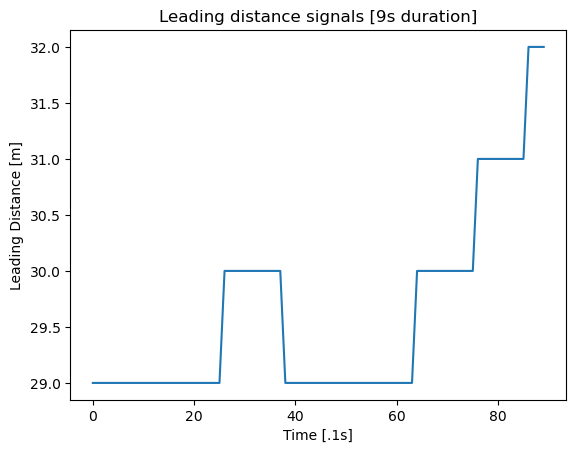

In [49]:
plt.plot(leading_dist_values[10:100])
plt.title("Leading distance signals [9s duration]")
plt.xlabel('Time [.1s]')
plt.ylabel('Leading Distance [m]')
plt.show()

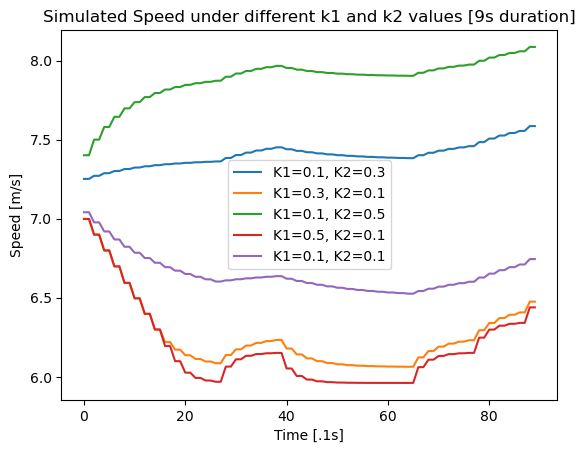

In [50]:
# Set the initial conditions
initial_conditions = [5, 6.9, 105, 10]  # Initial position and velocity

# Set the gain parameters KP and KD
K1_values = [0.1, 0.3, 0.1, 0.5, 0.1]  # Example values
K2_values = [0.3, 0.1, 0.5, 0.1, 0.1]  # Example values

# Simulate the system for different KP and KD values
for k1, k2 in zip(K1_values, K2_values):
    dist_values,v_values,acc_values = merge_control(k1,k2,initial_conditions[0],initial_conditions[1],initial_conditions[2],initial_conditions[3],dt_list,leading_dist_values)
    plt.plot(v_values[10:100],label=f'K1={k1}, K2={k2}')
plt.title("Simulated Speed under different k1 and k2 values [9s duration]")
plt.xlabel('Time [.1s]')
plt.ylabel('Speed [m/s]')
plt.legend()
plt.show()

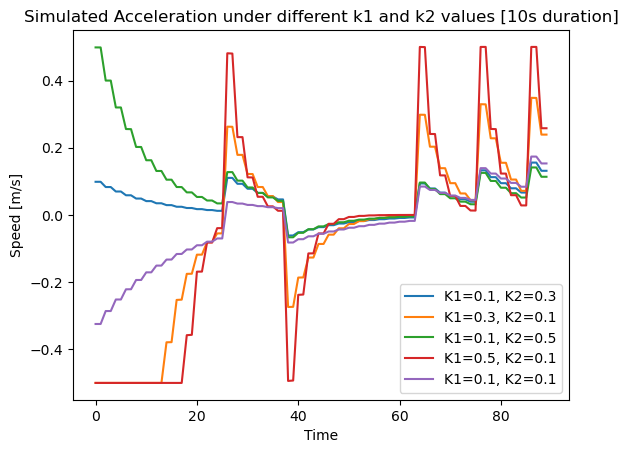

In [51]:
# Set the initial conditions
initial_conditions = [5, 6.9, 105, 10]  # Initial position and velocity

# Set the gain parameters KP and KD
K1_values = [0.1, 0.3, 0.1, 0.5, 0.1]  # Example values
K2_values = [0.3, 0.1, 0.5, 0.1, 0.1]  # Example values

# Simulate the system for different KP and KD values
for k1, k2 in zip(K1_values, K2_values):
    dist_values,v_values,acc_values = merge_control(k1,k2,initial_conditions[0],initial_conditions[1],initial_conditions[2],initial_conditions[3],dt_list,leading_dist_values)
    plt.plot(acc_values[10:100],label=f'K1={k1}, K2={k2}')
plt.title("Simulated Acceleration under different k1 and k2 values [10s duration]")
plt.xlabel('Time')
plt.ylabel('Speed [m/s]')
plt.legend()
plt.show()

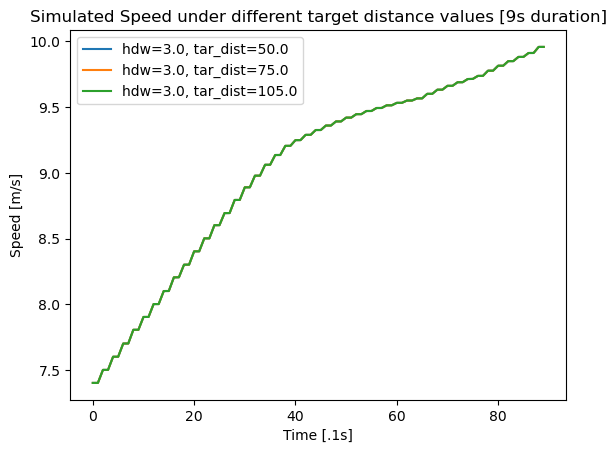

In [52]:
# Set the initial conditions
initial_conditions = [0.1, 0.1, 6.9, 10]  # Initial position and velocity

# Set the gain parameters KP and KD
hdw_values = [3.0, 3.0, 3.0]  # Example values
dist_tar_values = [50.0, 75.0, 105.0]  # Example values

# Simulate the system for different KP and KD values
for hdw_, dist_tar_ in zip(hdw_values, dist_tar_values):
    dist_values,v_values,acc_values = merge_control(initial_conditions[0],initial_conditions[1], hdw_, initial_conditions[2], dist_tar_, initial_conditions[3], dt_list,leading_dist_values)
    plt.plot(v_values[10:100],label=f'hdw={hdw_}, tar_dist={dist_tar_}')
plt.title("Simulated Speed under different target distance values [9s duration]")
plt.xlabel('Time [.1s]')
plt.ylabel('Speed [m/s]')
plt.legend()
plt.show()

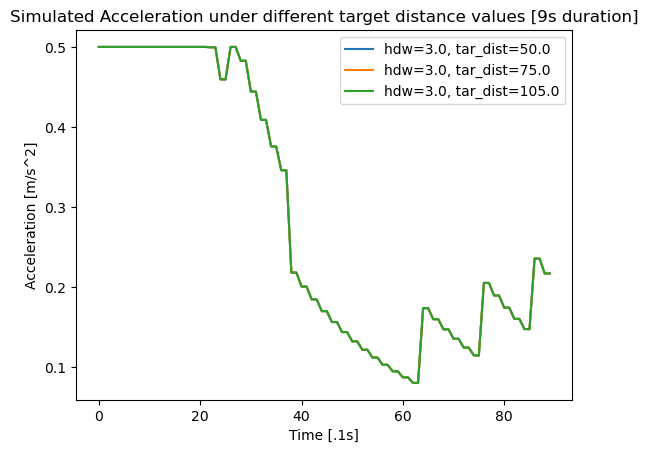

In [53]:
# Set the initial conditions
initial_conditions = [0.1, 0.1, 6.9, 10]  # Initial position and velocity

# Set the gain parameters KP and KD
hdw_values = [3.0, 3.0, 3.0]  # Example values
dist_tar_values = [50.0, 75.0, 105.0]  # Example values

# Simulate the system for different KP and KD values
for hdw_, dist_tar_ in zip(hdw_values, dist_tar_values):
    dist_values,v_values,acc_values = merge_control(initial_conditions[0],initial_conditions[1], hdw_, initial_conditions[2], dist_tar_, initial_conditions[3], dt_list,leading_dist_values)
    plt.plot(acc_values[10:100],label=f'hdw={hdw_}, tar_dist={dist_tar_}')
plt.title("Simulated Acceleration under different target distance values [9s duration]")
plt.xlabel('Time [.1s]')
plt.ylabel('Acceleration [m/s^2]')
plt.legend()
plt.show()

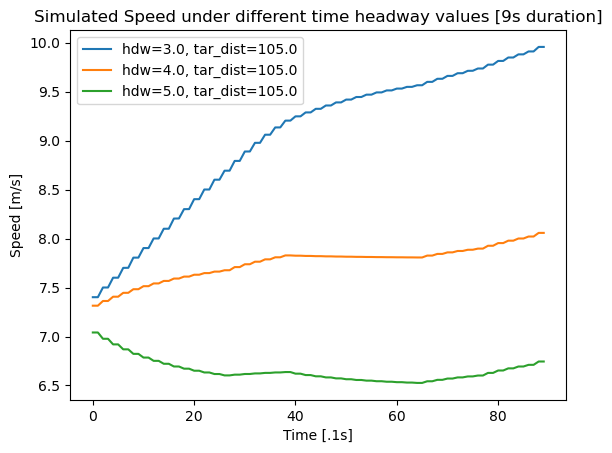

In [54]:
# Set the initial conditions
initial_conditions = [0.1, 0.1, 6.9, 10]  # Initial position and velocity

# Set the gain parameters KP and KD
hdw_values = [3.0, 4.0, 5.0]  # Example values
dist_tar_values = [105.0, 105.0, 105.0]  # Example values

# Simulate the system for different KP and KD values
for hdw_, dist_tar_ in zip(hdw_values, dist_tar_values):
    dist_values,v_values,acc_values = merge_control(initial_conditions[0],initial_conditions[1], hdw_, initial_conditions[2], dist_tar_, initial_conditions[3], dt_list,leading_dist_values)
    plt.plot(v_values[10:100],label=f'hdw={hdw_}, tar_dist={dist_tar_}')
plt.title("Simulated Speed under different time headway values [9s duration]")
plt.xlabel('Time [.1s]')
plt.ylabel('Speed [m/s]')
plt.legend()
plt.show()

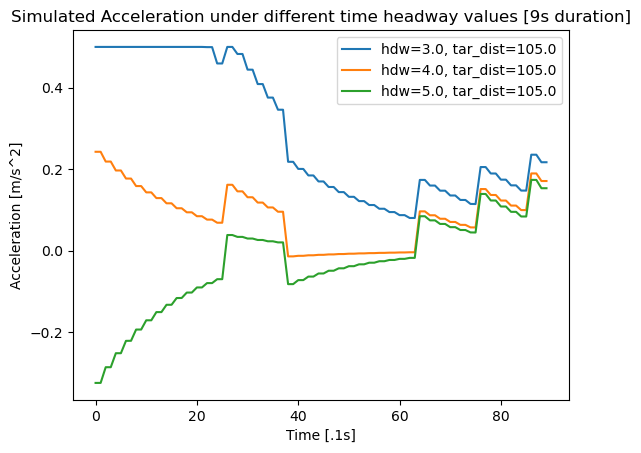

In [55]:
# Set the initial conditions
initial_conditions = [0.1, 0.1, 6.9, 10]  # Initial position and velocity

# Set the gain parameters KP and KD
hdw_values = [3.0, 4.0, 5.0]  # Example values
dist_tar_values = [105.0, 105.0, 105.0]  # Example values

# Simulate the system for different KP and KD values
for hdw_, dist_tar_ in zip(hdw_values, dist_tar_values):
    dist_values,v_values,acc_values = merge_control(initial_conditions[0],initial_conditions[1], hdw_, initial_conditions[2], dist_tar_, initial_conditions[3], dt_list,leading_dist_values)
    plt.plot(acc_values[10:100],label=f'hdw={hdw_}, tar_dist={dist_tar_}')
plt.title("Simulated Acceleration under different time headway values [9s duration]")
plt.xlabel('Time [.1s]')
plt.ylabel('Acceleration [m/s^2]')
plt.legend()
plt.show()

# more cars

In [56]:
alpha = 1.5 # acceleration gain
tau = 3 # desired time-gap

def CTH_accel(v,s,delta_v):
    # follows the constant time-gap car-following model:
    return alpha*(s - v*tau)

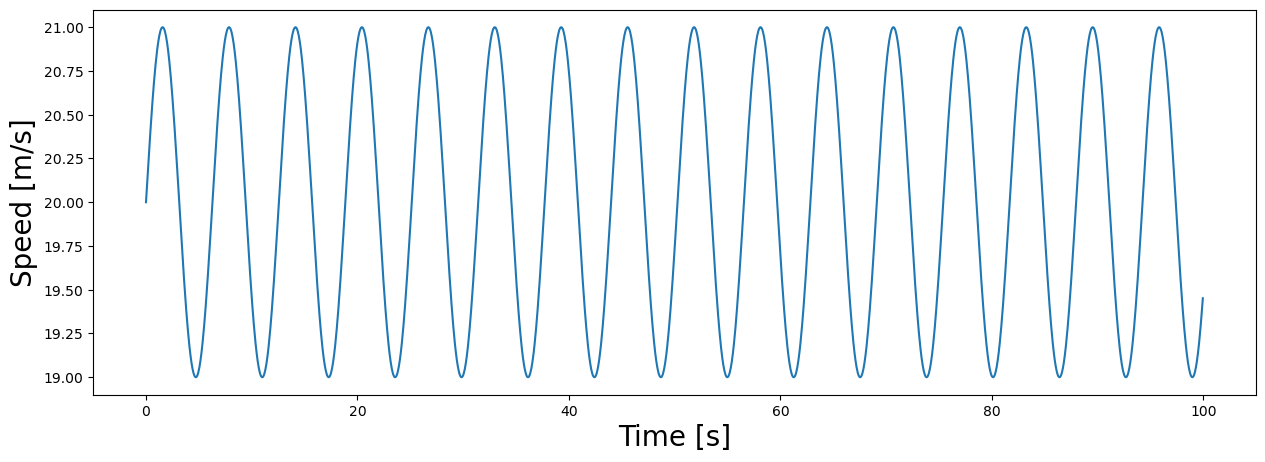

In [57]:
dt = 0.05 #Simulation fidelity
t_final = 100.0 #simulation duration
t = np.arange(0,t_final,dt) #time values
K = len(t) # number of simulation steps

v_l_values = np.sin(t) + 20.0 # the lead vehicle oscilates around 20 m/s

plt.figure(figsize=[15,5]) #make the figure aspect ratio wide
plt.plot(t,v_l_values)
_ = plt.ylabel('Speed [m/s]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)

In [58]:
s_values = [] # where we'll store spacing values
v_values = [] # speed values
delta_v_values = [] # speed differences values

# INITIAL CONDITIONS:
v_0 = 20.0 # begin at the same following speed as the leader
s_0 = v_0*tau #i.e., 10.0m, so we begin at the desired time-gap
delta_v_0 = v_l_values[0] - v_0


s_values.append(s_0) # store as first values
v_values.append(v_0)
delta_v_values.append(delta_v_0)

In [59]:
for k in range(1,K):# Have already accounted for k = 0, start with k = 1


    # At every iteration, look at what the last value we calculated was:
    s_t_k = s_values[-1]
    v_t_k = v_values[-1]
    delta_v_t_k = v_l_values[k-1] - v_t_k

    # apply the Euler finite-difference integration scheme:
    a_t_k = CTH_accel(v=v_t_k,s=s_t_k,delta_v=delta_v_t_k)

    # apply the update rule to find a new state:
    s_t_k_plus_1 = s_t_k + dt*delta_v_t_k
    v_t_k_plus_1 = v_t_k + dt*a_t_k

    # add newly calculated states to the recorded values:
    v_values.append(v_t_k_plus_1)
    s_values.append(s_t_k_plus_1)



print('Simulation finished.')

Simulation finished.


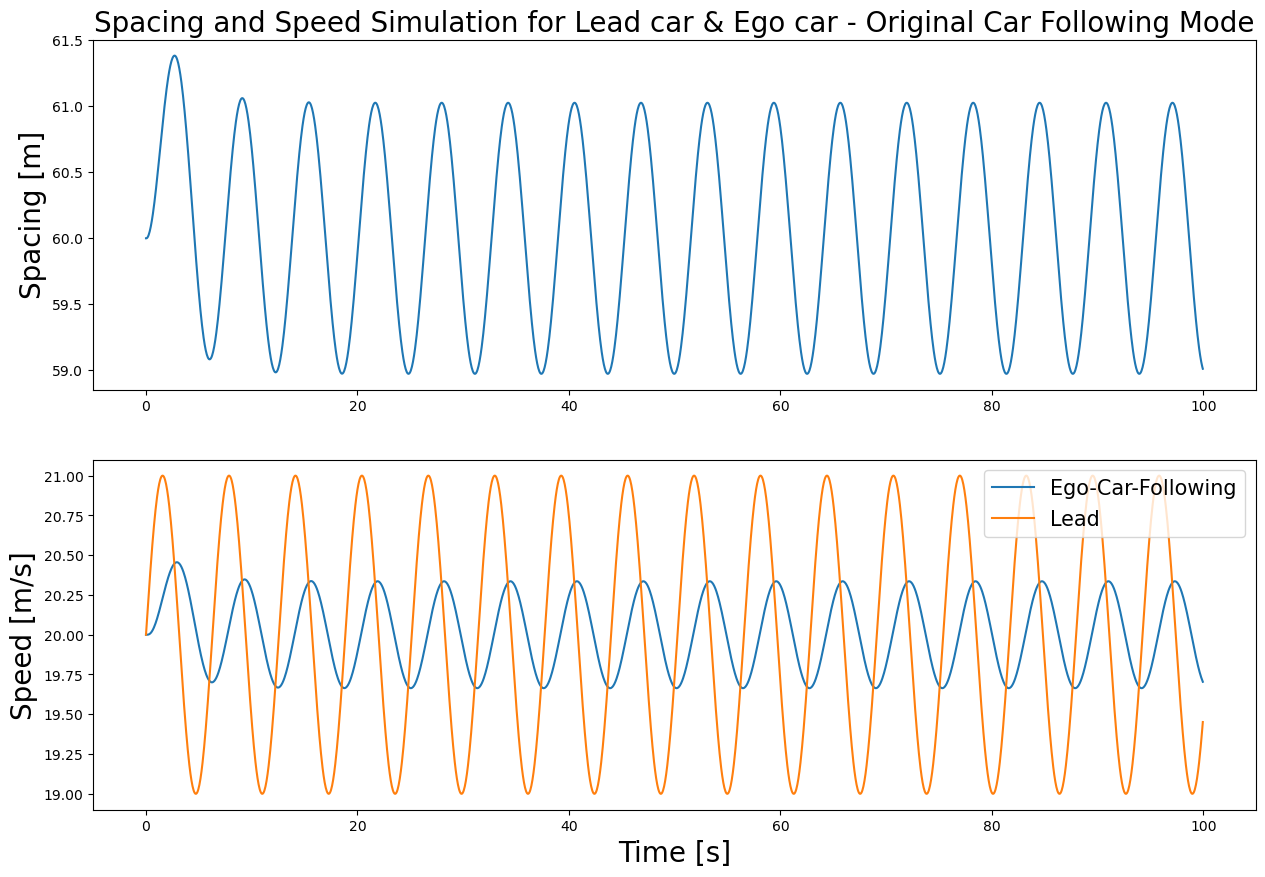

In [60]:
plt.figure(figsize=[15,10])

plt.subplot(2,1,1)
plt.plot(t,s_values)
_ = plt.title('Spacing and Speed Simulation for Lead car & Ego car - Original Car Following Mode',fontsize=20)
_ = plt.ylabel('Spacing [m]',fontsize=20)


plt.subplot(2,1,2)
plt.plot(t,v_values,label='Ego-Car-Following')
plt.plot(t,v_l_values,label='Lead')
plt.legend(fontsize=15)
_ = plt.ylabel('Speed [m/s]',fontsize=20)
_ = plt.xlabel('Time [s]',fontsize=20)

In [61]:
k1 = 0.1
k2 = 0.1
hdw = 3
dist_target = 105
v_desire = 15
v_0 = 20

def Merge_accel(v,s,k1,k2,hdw,dist_target,v_desire):
    # give more spacing for the merging car
    dist = min(dist_target,s)
    acc = k1 * (dist - hdw * v) + k2 * (v_desire - v)
    acc_act = max(min(0.5,acc),-0.5)
    return acc_act

In [62]:
s_values = [] # where we'll store spacing values
v_values = [] # speed values
delta_v_values = [] # speed differences values

# INITIAL CONDITIONS:
v_0 = 20.0 # begin at the same following speed as the leader
s_0 = v_0*hdw #i.e., 10.0m, so we begin at the desired time-gap
delta_v_0 = v_l_values[0] - v_0


s_values.append(s_0) # store as first values
v_values.append(v_0)
delta_v_values.append(delta_v_0)

In [63]:
for k in range(1,K):# Have already accounted for k = 0, start with k = 1


    # At every iteration, look at what the last value we calculated was:
    s_t_k = s_values[-1]
    v_t_k = v_values[-1]
    delta_v_t_k = v_l_values[k-1] - v_t_k

    # apply the Euler finite-difference integration scheme:
    a_t_k = Merge_accel(v_t_k,s_t_k,k1,k2,hdw,dist_target,v_desire)

    # apply the update rule to find a new state:
    s_t_k_plus_1 = s_t_k + dt*delta_v_t_k
    v_t_k_plus_1 = v_t_k + dt*a_t_k

    # add newly calculated states to the recorded values:
    v_values.append(v_t_k_plus_1)
    s_values.append(s_t_k_plus_1)



print('Simulation finished.')

Simulation finished.


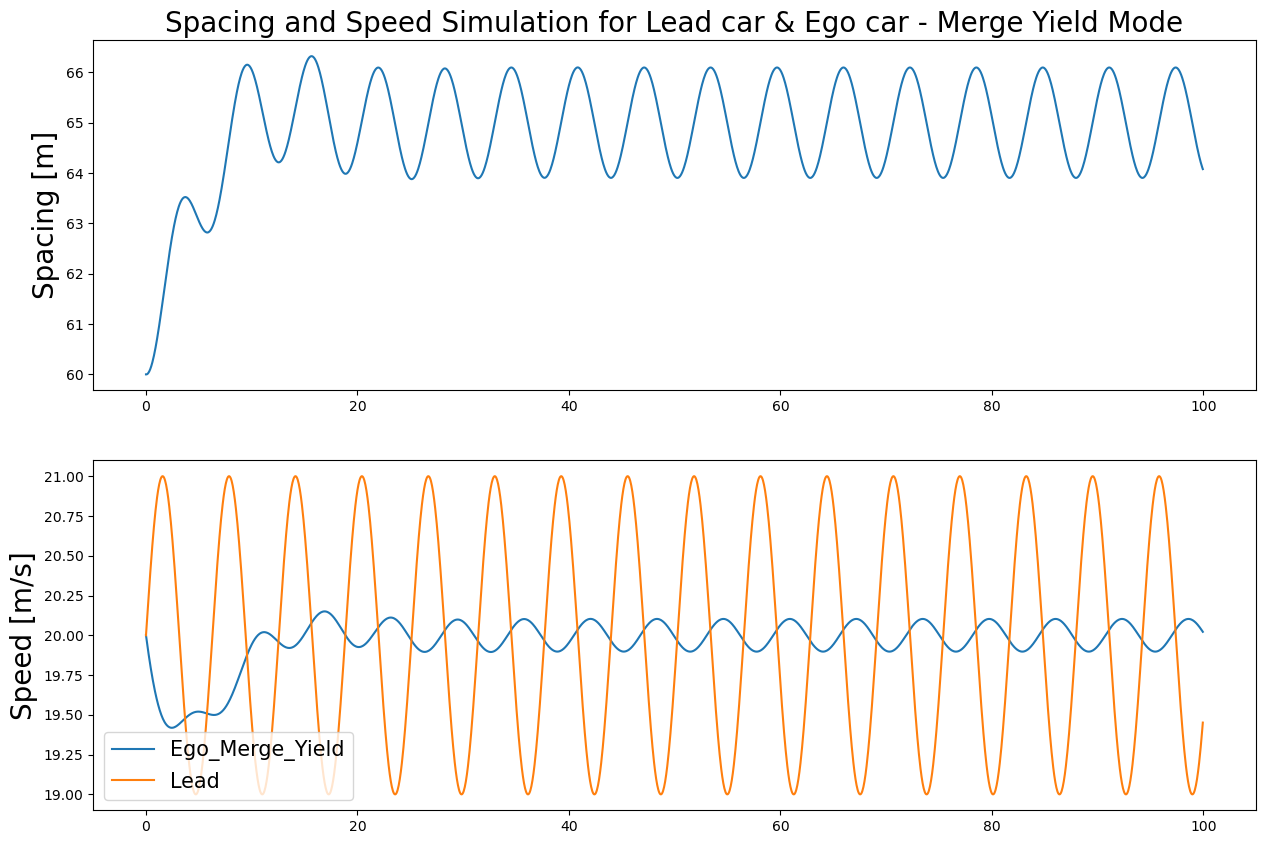

In [64]:
plt.figure(figsize=[15,10])

plt.subplot(2,1,1)
plt.plot(t,s_values)
_ = plt.title('Spacing and Speed Simulation for Lead car & Ego car - Merge Yield Mode',fontsize=20)
_ = plt.ylabel('Spacing [m]',fontsize=20)


plt.subplot(2,1,2)
plt.plot(t,v_values,label='Ego_Merge_Yield')
plt.plot(t,v_l_values,label='Lead')
plt.legend(fontsize=15)
_ = plt.ylabel('Speed [m/s]',fontsize=20)

# creare the simulation fuction

## original time gap car-following mode

In [65]:
def CTH_accel(v,s,delta_v,alpha,tau):
    # follows the constant time-gap car-following model:
    return alpha*(s - v*tau)


def simulate_CTH(alpha,
                 tau,
                 v_l_values=np.sin(t) + 20.0):
    '''
    This function will perform the euler simulation
    using specified Car following model parameters and a lead vehicle input profile
    '''

    #check stability
    if tau>=2*np.sqrt(alpha):
        print("alpha="+ str(alpha) +" and tau="+ str(tau) + ' are string stable')
    else:
        print("alpha="+ str(alpha) +" and tau="+ str(tau) + ' are string unstable')

    # SIMULATION PARAMETERS:
    dt = 0.05 #Simulation fidelity
    t_final = 100.0 #simulation duration
    t = np.arange(0,t_final,dt) #time values
    K = len(t) # number of simulation steps

    # STATE VALUES:
    s_values = [] # where we'll store spacing values
    v_values = [] # speed values
    delta_v_values = [] # speed differences values

    # INITIAL CONDITIONS:
    v_0 = 20.0 # begin at the same following speed as the leader
    s_0 = v_0*tau # begin at the desired time-gap
    delta_v_0 = v_l_values[0] - v_0


    s_values.append(s_0) # store as first values
    v_values.append(v_0)
    delta_v_values.append(delta_v_0)

    for k in range(1,K):# Have already accounted for k = 0, start with k = 1

        # At every iteration, look at what the last value we calculated was:
        s_t_k = s_values[-1]
        v_t_k = v_values[-1]
        delta_v_t_k = v_l_values[k-1] - v_t_k

        # apply the Euler finite-difference integration scheme:
        a_t_k = CTH_accel(v=v_t_k,s=s_t_k,delta_v=delta_v_t_k,alpha=alpha,tau=tau)

        # apply the update rule to find a new state:
        v_t_k_plus_1 = v_t_k + dt*a_t_k
        s_t_k_plus_1 = s_t_k + dt*delta_v_t_k

        # add newly calculated states to the recorded values:
        v_values.append(v_t_k_plus_1)
        s_values.append(s_t_k_plus_1)

    print('simulation finsihed.')

    return [t,s_values,v_values,delta_v_values,v_l_values]

In [66]:
# Here's an example of to run that does the same simulation as previously:
[t,s_values,v_values,delta_v_values,v_l_values] = simulate_CTH(alpha=1.5,tau=0.5)

alpha=1.5 and tau=0.5 are string unstable
simulation finsihed.


## merge yeild mode

In [67]:
k1 = 0.1
k2 = 0.1
hdw = 3
dist_target = 105
v_desire = 15
v_0 = 20

def Merge_accel(v,s,k1,k2,hdw,dist_target,v_desire):
    # give more spacing for the merging car
    dist = min(dist_target,s)
    acc = k1 * (dist - hdw * v) + k2 * (v_desire - v)
    acc_act = max(min(0.5,acc),-0.5)
    return acc_act


def simulate_Merge(k1,k2,hdw,dist_target,v_desire,
                 v_l_values=np.sin(t) + 20.0):
    '''
    This function will perform the euler simulation
    using specified Car following model parameters and a lead vehicle input profile
    '''

    #check stability
#     if tau>=2*np.sqrt(alpha):
#         print("alpha="+ str(alpha) +" and tau="+ str(tau) + ' are string stable')
#     else:
#         print("alpha="+ str(alpha) +" and tau="+ str(tau) + ' are string unstable')

    # SIMULATION PARAMETERS:
    dt = 0.05 #Simulation fidelity
    t_final = 100.0 #simulation duration
    t = np.arange(0,t_final,dt) #time values
    K = len(t) # number of simulation steps

    # STATE VALUES:
    s_values = [] # where we'll store spacing values
    v_values = [] # speed values
    delta_v_values = [] # speed differences values

    # INITIAL CONDITIONS:
    v_0 = 20.0 # begin at the same following speed as the leader
    s_0 = v_0*hdw # begin at the desired time-gap
    delta_v_0 = v_l_values[0] - v_0


    s_values.append(s_0) # store as first values
    v_values.append(v_0)
    delta_v_values.append(delta_v_0)

    for k in range(1,K):# Have already accounted for k = 0, start with k = 1

        # At every iteration, look at what the last value we calculated was:
        s_t_k = s_values[-1]
        v_t_k = v_values[-1]
        delta_v_t_k = v_l_values[k-1] - v_t_k

        # apply the Euler finite-difference integration scheme:
        a_t_k = Merge_accel(v_t_k,s_t_k,k1,k2,hdw,dist_target,v_desire)

        # apply the update rule to find a new state:
        v_t_k_plus_1 = v_t_k + dt*a_t_k
        s_t_k_plus_1 = s_t_k + dt*delta_v_t_k

        # add newly calculated states to the recorded values:
        v_values.append(v_t_k_plus_1)
        s_values.append(s_t_k_plus_1)

    print('simulation finsihed.')

    return [t,s_values,v_values,delta_v_values,v_l_values]

In [68]:
# Here's an example of to run that does the same simulation as previously:
[t,s_values,v_values,delta_v_values,v_l_values] = simulate_Merge(k1=0.1,k2=0.1,hdw=3,dist_target=105,v_desire=15)

simulation finsihed.


## more cars - CTH

In [69]:
def calculate_accumulated_odometer(velocity, dt, s_0, i):
    # Initialize variables
    accumulated_odometer = [0]
    position = 0 + i * s_0

    # Iterate through the velocity array
    for v in velocity:
        displacement = v * dt
        position += displacement
        accumulated_odometer.append(position)

    return accumulated_odometer

In [70]:
# we'll store the different measured speeds here:
all_v_values = []
all_odo_values = []

# simulate the first follower:
#[t,s_values,v_values,delta_v_values,v_l_values] = simulate_CTH(alpha=1.5,tau=0.5)
#[t,s_values,v_values,delta_v_values,v_l_values] = simulate_CTH(alpha=0.1,tau=0.5)
[t,s_values,v_values,delta_v_values,v_l_values] = simulate_CTH(alpha=1.0,tau=2.5)
all_v_values.append(v_values)

odo_values = calculate_accumulated_odometer(v_values, 0.05, 0, 60)
all_odo_values.append(odo_values)


num_following_vehicles = 10

for i in range(num_following_vehicles):
    v_l_values = v_values # use the last speed profile as the new lead input:
    [t,s_values,v_values,delta_v_values,v_l_values] = simulate_CTH(alpha=.1,tau=2.5,v_l_values=v_l_values)
    all_v_values.append(v_values)
    odo_values = calculate_accumulated_odometer(v_values, 0.05, i+1, 20*3)
    all_odo_values.append(odo_values)


alpha=1.0 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.
alpha=0.1 and tau=2.5 are string stable
simulation finsihed.


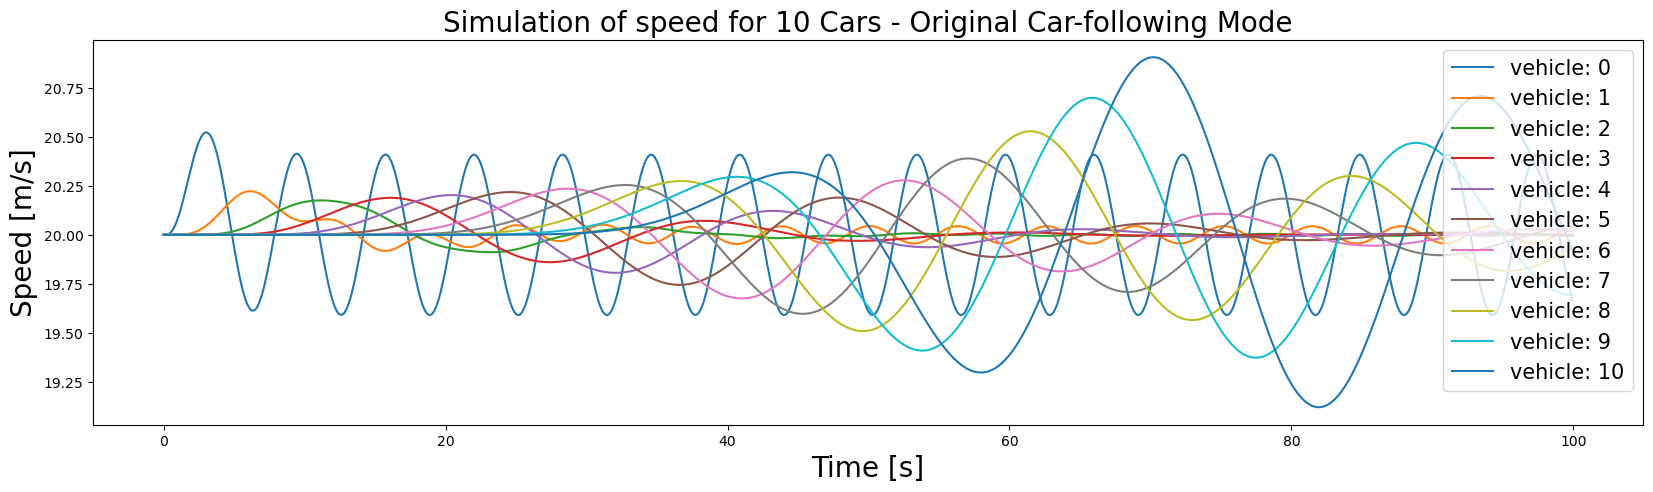

In [71]:
plt.figure(figsize=[20,5])

for i,v_values in enumerate(all_v_values):
    plt.plot(t,v_values,label='vehicle: '+str(i)) #label every vehicle

plt.legend(fontsize=15)
plt.title('Simulation of speed for 10 Cars - Original Car-following Mode',fontsize=20)
plt.ylabel('Speed [m/s]',fontsize=20)
plt.xlabel('Time [s]',fontsize=20)
plt.show()

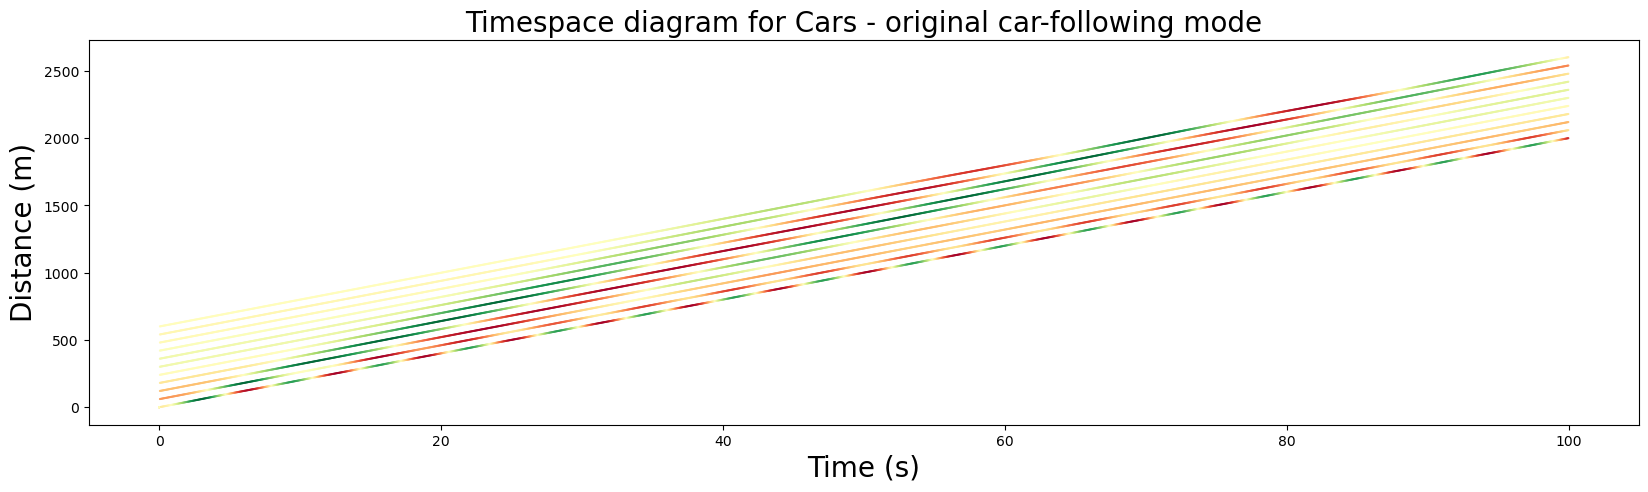

In [72]:
plt.figure(figsize=[20,5])

for i,odo_values in enumerate(all_odo_values):
    plt.scatter(x=t,y=odo_values[:-1],c=all_v_values[i],cmap='RdYlGn',marker='.',sizes=[1])

#plt.legend(fontsize=15)
plt.title('Timespace diagram for Cars - original car-following mode',fontsize=20)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Distance (m)',fontsize=20)
plt.show()

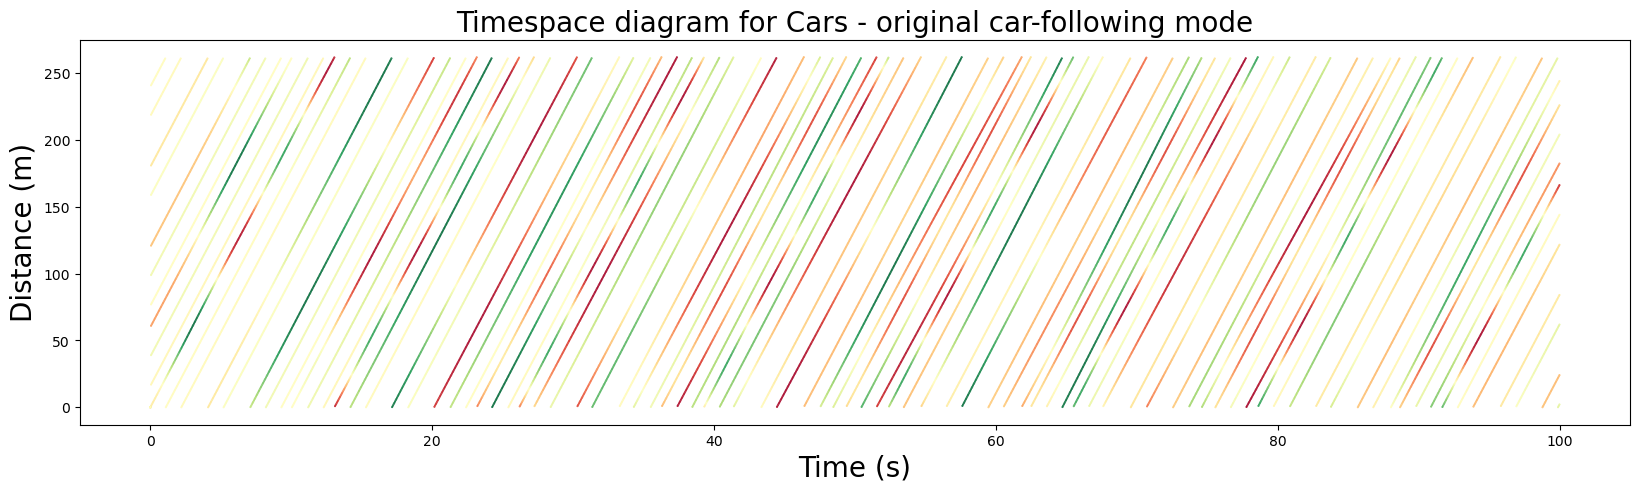

In [73]:
plt.figure(figsize=[20,5])

for i,odo_values in enumerate(all_odo_values):
    mod_result_list = [x % 262 for x in odo_values[:-1]]
    plt.scatter(x=t,y=mod_result_list,c=all_v_values[i],cmap='RdYlGn',marker='.',sizes=[1])

#plt.legend(fontsize=15)
plt.title('Timespace diagram for Cars - original car-following mode',fontsize=20)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Distance (m)',fontsize=20)
plt.show()

## more cars - Merge

In [74]:
# we'll store the different measured speeds here:
all_v_values = []

[t,s_values,v_values,delta_v_values,v_l_values] = simulate_Merge(k1=0.1,k2=0.1,hdw=3,dist_target=105,v_desire=15)
all_v_values.append(v_values)

num_following_vehicles = 10

for i in range(num_following_vehicles):
    v_l_values = v_values # use the last speed profile as the new lead input:
    [t,s_values,v_values,delta_v_values,v_l_values] = simulate_Merge(k1=0.1,k2=0.1,hdw=3,dist_target=105,v_desire=15, v_l_values=v_l_values)
    all_v_values.append(v_values)

simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.
simulation finsihed.


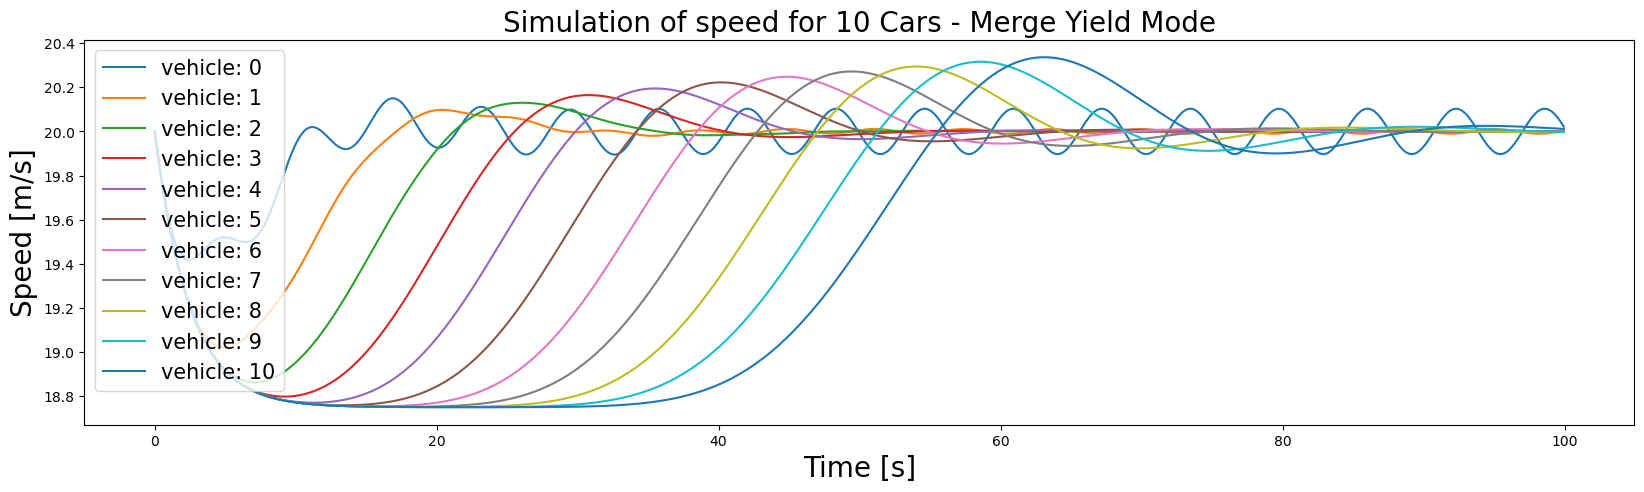

In [75]:
plt.figure(figsize=[20,5])

for i,v_values in enumerate(all_v_values):
    plt.plot(t,v_values,label='vehicle: '+str(i)) #label every vehicle

plt.legend(fontsize=15)
plt.title('Simulation of speed for 10 Cars - Merge Yield Mode',fontsize=20)
plt.ylabel('Speed [m/s]',fontsize=20)
plt.xlabel('Time [s]',fontsize=20)
plt.show()

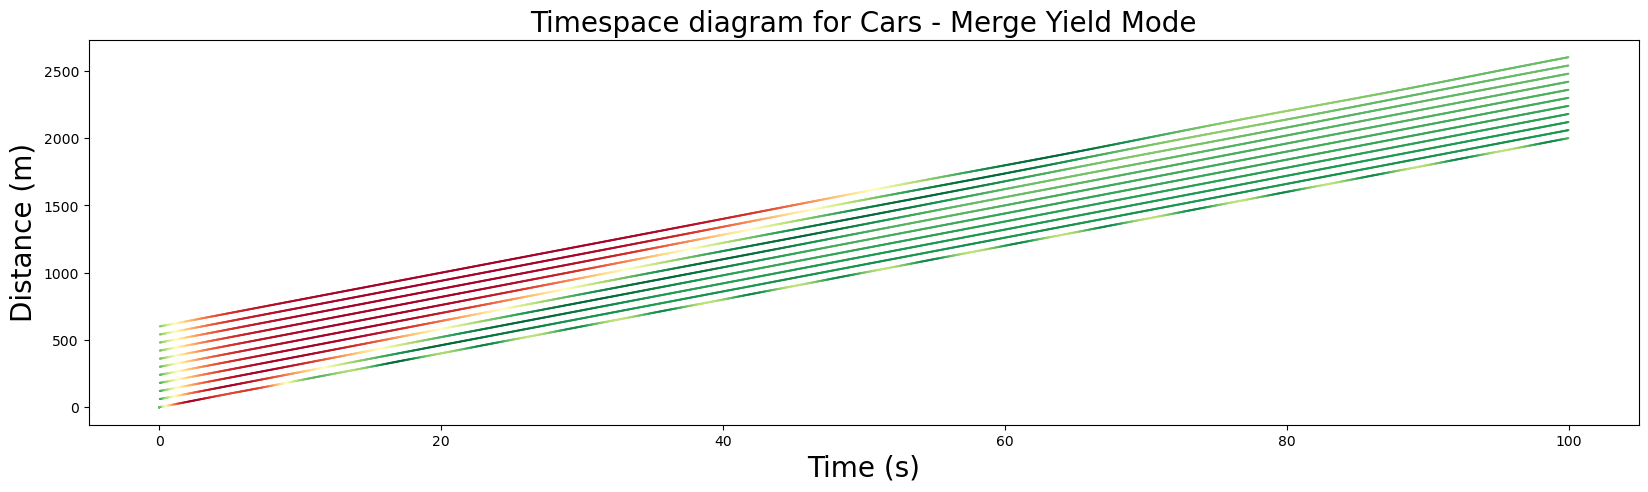

In [76]:
plt.figure(figsize=[20,5])

for i,odo_values in enumerate(all_odo_values):
    plt.scatter(x=t,y=odo_values[:-1],c=all_v_values[i],cmap='RdYlGn',marker='.',sizes=[1])

#plt.legend(fontsize=15)
plt.title('Timespace diagram for Cars - Merge Yield Mode',fontsize=20)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Distance (m)',fontsize=20)
plt.show()

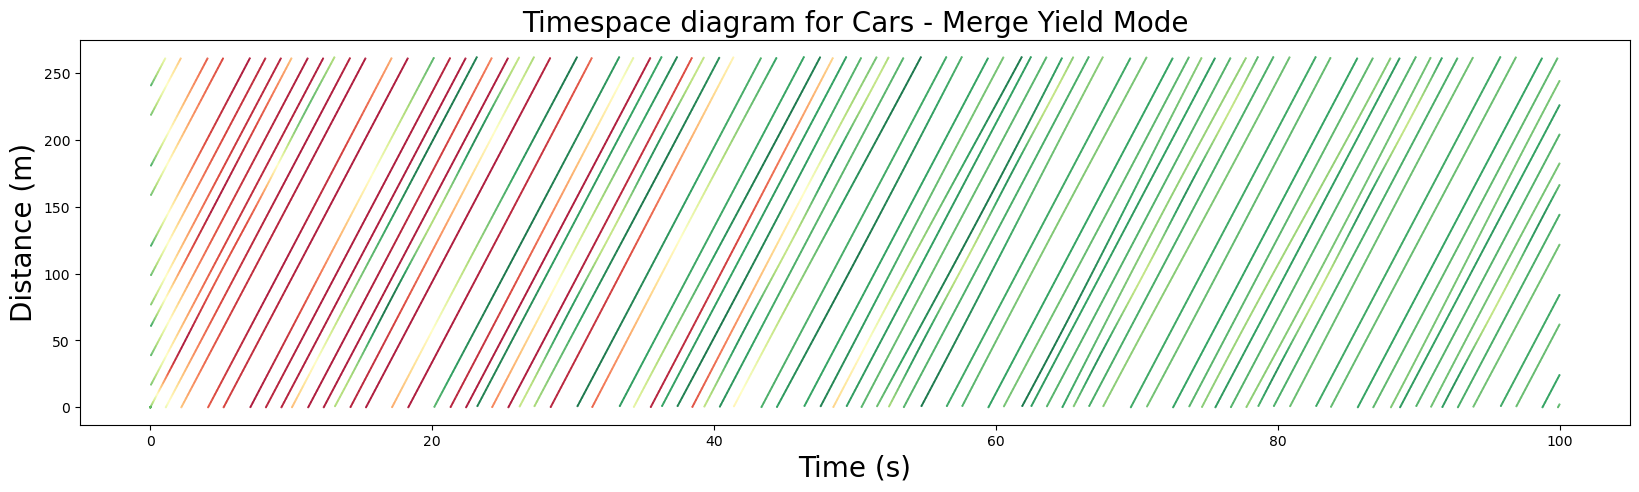

In [77]:
plt.figure(figsize=[20,5])

for i,odo_values in enumerate(all_odo_values):
    mod_result_list = [x % 262 for x in odo_values[:-1]]
    plt.scatter(x=t,y=mod_result_list,c=all_v_values[i],cmap='RdYlGn',marker='.',sizes=[1])

#plt.legend(fontsize=15)
plt.title('Timespace diagram for Cars - Merge Yield Mode',fontsize=20)
plt.xlabel('Time (s)',fontsize=20)
plt.ylabel('Distance (m)',fontsize=20)
plt.show()